In [10]:
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/4_Web crawler/1218_course')  #👍

current_path = os.getcwd()
print("當前工作目錄是：", current_path)

當前工作目錄是： c:\Users\User\Dropbox\0_Coding\0_github_repo\my_analysis_projects\time_series_analysis


# 匯入必要套件

(若無以下套件，則可輸入 (!pip install 套件名稱) 

如 ! pip install statsmodels.tsa.stattools
或是直接於terminal輸入 pip install 套件名稱)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #設定座標軸日期

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #ADF檢驗用

import matplotlib as mpl

2. 匯入檔案

            buzz
Time            
2021-01-01     9
2021-01-02    21
2021-01-03    20
2021-01-04    29
2021-01-05    70
...          ...
2023-06-26   151
2023-06-27   243
2023-06-28   203
2023-06-29   144
2023-06-30   153

[911 rows x 1 columns]


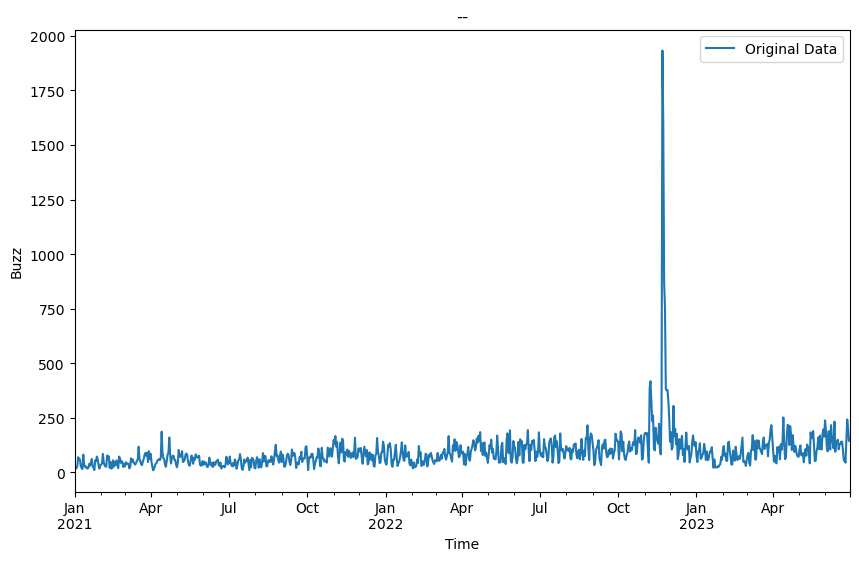

平均聲量:93.74753018660812


In [18]:
# 讀取csv檔案並解析日期欄位
url_base = '綠色飲食/' #🫵輸入目標檔案路徑
file_name = '綠色飲食聲量趨勢.csv' #🫵輸入檔案名稱
url = url_base+file_name
df = pd.read_csv(url, parse_dates=['Time']) #讀取csv檔案，將Time欄位設定為時間格式
df.set_index('Time', inplace=True) #將Time轉為表格的Index，時間序列重要

new_col_name = 'buzz'
df.rename(columns={df.columns[0]: new_col_name}, inplace=True)

#時間序列模型中，乘法模型的使用不得為0，若遇到聲量有0的狀況，全體+1
if (df['buzz']==0).any():
  df['buzz'] = df['buzz']+1

print(df)

#資料繪圖
plt.figure(figsize=(10,6))
df['buzz'].plot(label=('Original Data'))
plt.xlabel('Time')
plt.ylabel('Buzz')
plt.title('--')
plt.legend()  # 顯示圖例
plt.show()

average_value = df[new_col_name].mean()
print(f'平均聲量:{average_value}')

3. 偵測並移除極端值。

方法：(z-score)偵測極端值，並透過迭代方式取代：處理後資料表名稱:df_new

        Time  buzz
0 2022-11-08   418
1 2022-11-22  1933
2 2022-11-23  1595
3 2022-11-24   870
4 2022-11-25   758
極端值數據已存取於
綠色飲食/

以下為極端數據資料



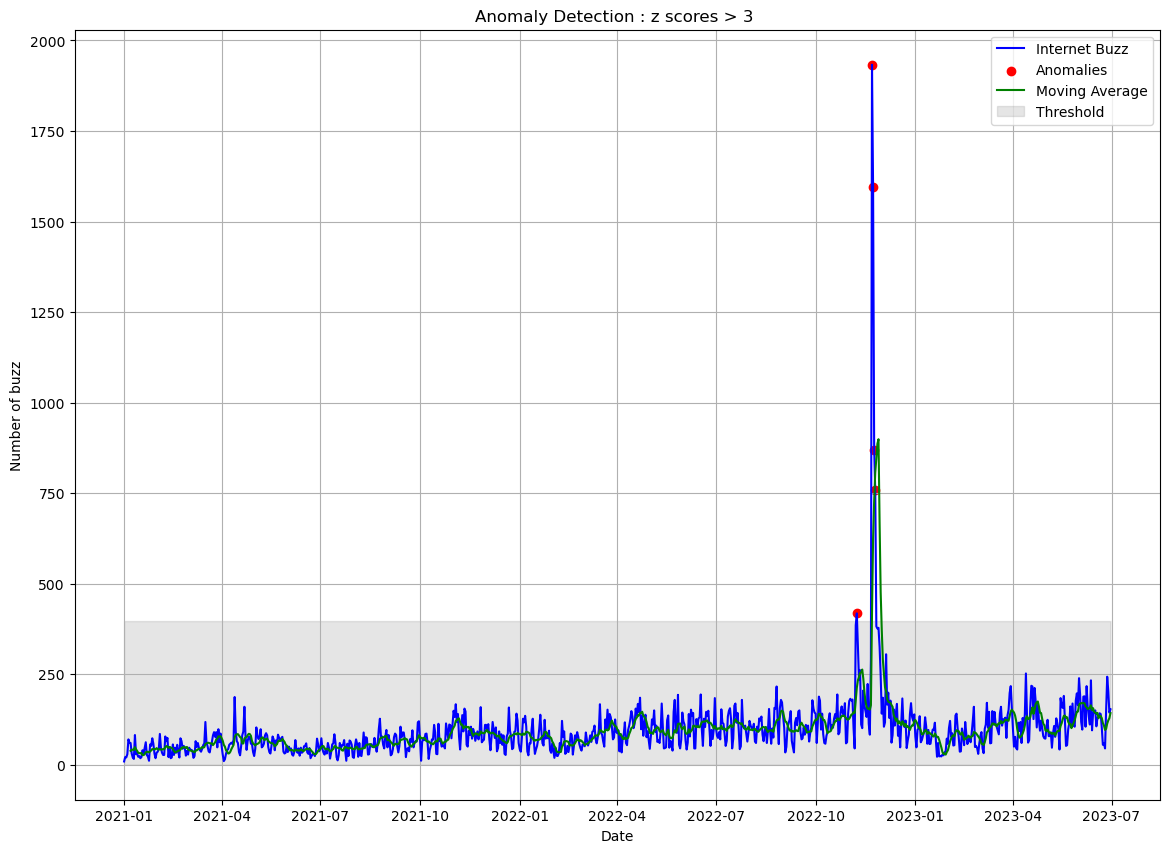

C:\Users\User\AppData\Local\Temp\ipykernel_43972\604810004.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '212.42857142857142' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_used.loc[index_to_replace, column_name] = ma[index_to_replace]


共處理了 6 個極端值
        Time
0 2022-11-08
1 2022-11-22
2 2022-11-22
3 2022-11-23
4 2022-11-24
5 2022-11-25


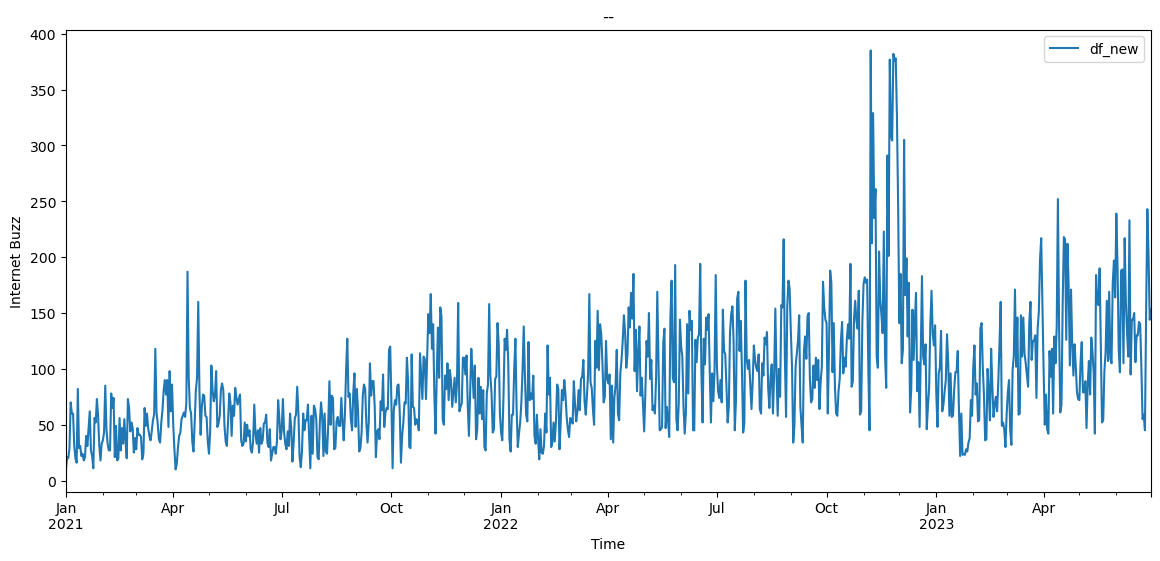


單位平均聲量:89.16917556370748


In [19]:
#(z-score)偵測極端值，並透過迭代方式取代

z_determination = 3 #🫵 定義極端事件。選擇極端事件罰直，表示極端程度。(1.96 = 95%, 2.33 = 99%, 3 =99.7%)，百分比表示常態分佈下的極端事件發生比例
# z-score 參考資料 https://www.socscistatistics.com/tests/ztest/zscorecalculator.aspx
window_size = 7 #🫵 選擇合適區間，用於計算移動平均聲量，取代極端事件聲量。假設window_size設定7，極端事件當日聲量被過去7天的平均聲量取代

def replace_outliers_with_z(df,column_name,window_size,z_determination):
  #計算滾動平均
  df_used = df.copy()
  mean = df_used[column_name].mean()

  #設定閥值
  z_determination = z_determination

  #計算資料點與滾動平均差異
  deviation = df_used[column_name] - mean
  threshold = z_determination * deviation.std()

  #標記極端值
  anomalies = df_used[deviation>threshold] #可直接輸入判斷式
  anomalies = anomalies.rename_axis('Time')
  df_plot = df_used.reset_index()
  anomalies_plot = anomalies.reset_index()

  #極端值數據儲存csv
  print(anomalies_plot)
  anomalies_plot.to_csv(url_base+'極端值數據_z-score.csv',index=True)
  print(f'極端值數據已存取於\n{url_base}\n\n以下為極端數據資料\n')

  ma = df[column_name].rolling(window_size).mean()
  # 繪製聲量趨勢圖與極端值
  plt.subplots(figsize=(14, 10)) # subplot可以允許多種子圖 (折線圖、散步圖)
  plt.plot(df_plot['Time'], df_plot[column_name], color='blue', label='Internet Buzz')
  plt.scatter(anomalies_plot['Time'], anomalies_plot[column_name], color='red', label='Anomalies')
  plt.plot(df_plot['Time'], ma, color='green', label='Moving Average')
  plt.fill_between(df_plot['Time'], 0, mean+threshold, color='gray', alpha=0.2, label='Threshold')
  plt.legend()
  plt.title(f'Anomaly Detection : z scores > {z_determination} ')
  plt.xlabel('Date')
  plt.ylabel('Number of buzz')
  plt.grid() # 添加網格
  plt.savefig(url_base+'極端值檢測_z-score.png')  # Save the plot as an image
  plt.show()

  #迭代處理極端值
  processed_indices = []  # 存儲已處理的極端值的索引

  while True:
    deviation = df_used[column_name] - mean
    anomalies = df_used[deviation.abs() > threshold]

    if anomalies.empty:
        break

    # 取出第一個極端值的索引
    index_to_replace = anomalies.index[0]
    processed_indices.append(index_to_replace)

    # 取代極端值為當前滾動平均值
    ma = df_used[column_name].rolling(window_size).mean()
    df_used.loc[index_to_replace, column_name] = ma[index_to_replace]

  print(f'共處理了 {len(processed_indices)} 個極端值')
  df_indices = pd.DataFrame({'Time':processed_indices})
  print(df_indices)

  return df_used

df_new = replace_outliers_with_z(df,new_col_name,window_size,z_determination)

#原始資料檢測
plt.figure(figsize=(14,6))
df_new[new_col_name].plot(label=('df_new'))
plt.xlabel('Time')
plt.ylabel('Internet Buzz')
plt.title('--')
plt.legend()  # 顯示圖例
plt.show()

average_value = df_new[new_col_name].mean()
print(f'\n單位平均聲量:{average_value}')

4. 設定時間間隔

若只需要原始資料，在unit端保留D即可，不過以週(W)或雙週(2W)來看，最後給客戶呈現比較好做圖。

In [21]:
units = ['D','W','2W'] #🫵 D=Day, W=Week, SM=Semi-Monthly, M=Month, Q=Quaterly, Y=year，前面可加數字 3D=3Day

#🫵根據所選時間間隔，必須要有對應週期，作為後續
periods_to_tes_list = [[int(365/2), 365], # D的半年週期與一年週期
           [int(52/2),52],   # W的半年週期與一年週期
           [int(26/2),26]]   # 2W的半年週期與一年週期

def create_timeframe_data(df,units):
  df_new_list = []
  df_name_list = []
  for unit in units:
    df_new = df.resample(unit).sum()
    df_name = 'time interval: '+ unit
    df_new_list.append(df_new)
    df_name_list.append(df_name)

  return df_new_list, df_name_list

df_new_list, df_name_list = create_timeframe_data(df_new,units)

自動化季節性偵測

Period: 182, Model: additive, 殘差值的絕對值平均： 25.25165513460741
Period: 182, Model: multiplicative, 殘差值的絕對值平均： 0.9972278060120585
Period: 365, Model: additive, 殘差值的絕對值平均： 15.472485966956937
Period: 365, Model: multiplicative, 殘差值的絕對值平均： 1.0136651604862323


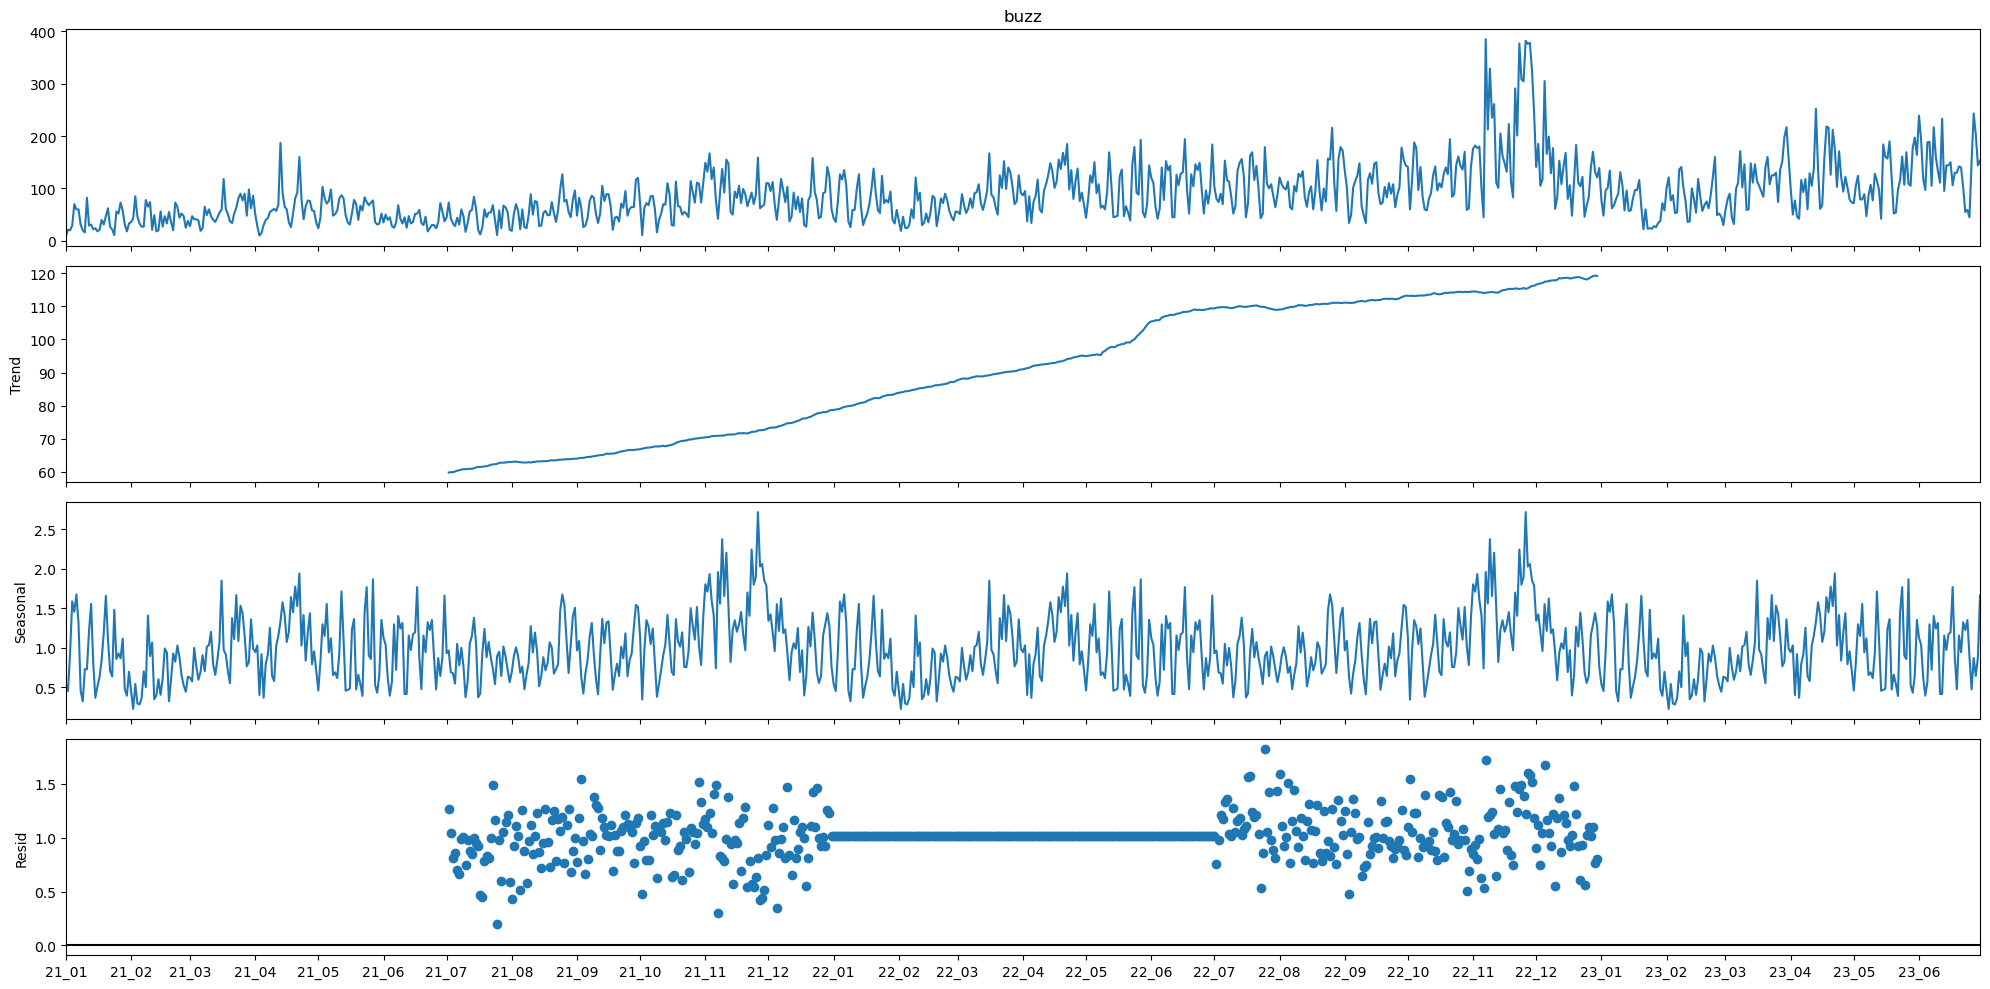

上圖已儲存至綠色飲食
上圖數據資料已儲存至綠色飲食
分析資料表: time interval: D
單位平均聲量: buzz    89.169176
dtype: float64
最佳模型： Model: multiplicative, Period: 182,  最小的殘差值的絕對值平均： 0.9972278060120585


-------------------------------------------
Period: 26, Model: additive, 殘差值的絕對值平均： 127.82383428415665
Period: 26, Model: multiplicative, 殘差值的絕對值平均： 0.9983950109186843
Period: 52, Model: additive, 殘差值的絕對值平均： 64.52868257854827
Period: 52, Model: multiplicative, 殘差值的絕對值平均： 1.0144977101112962


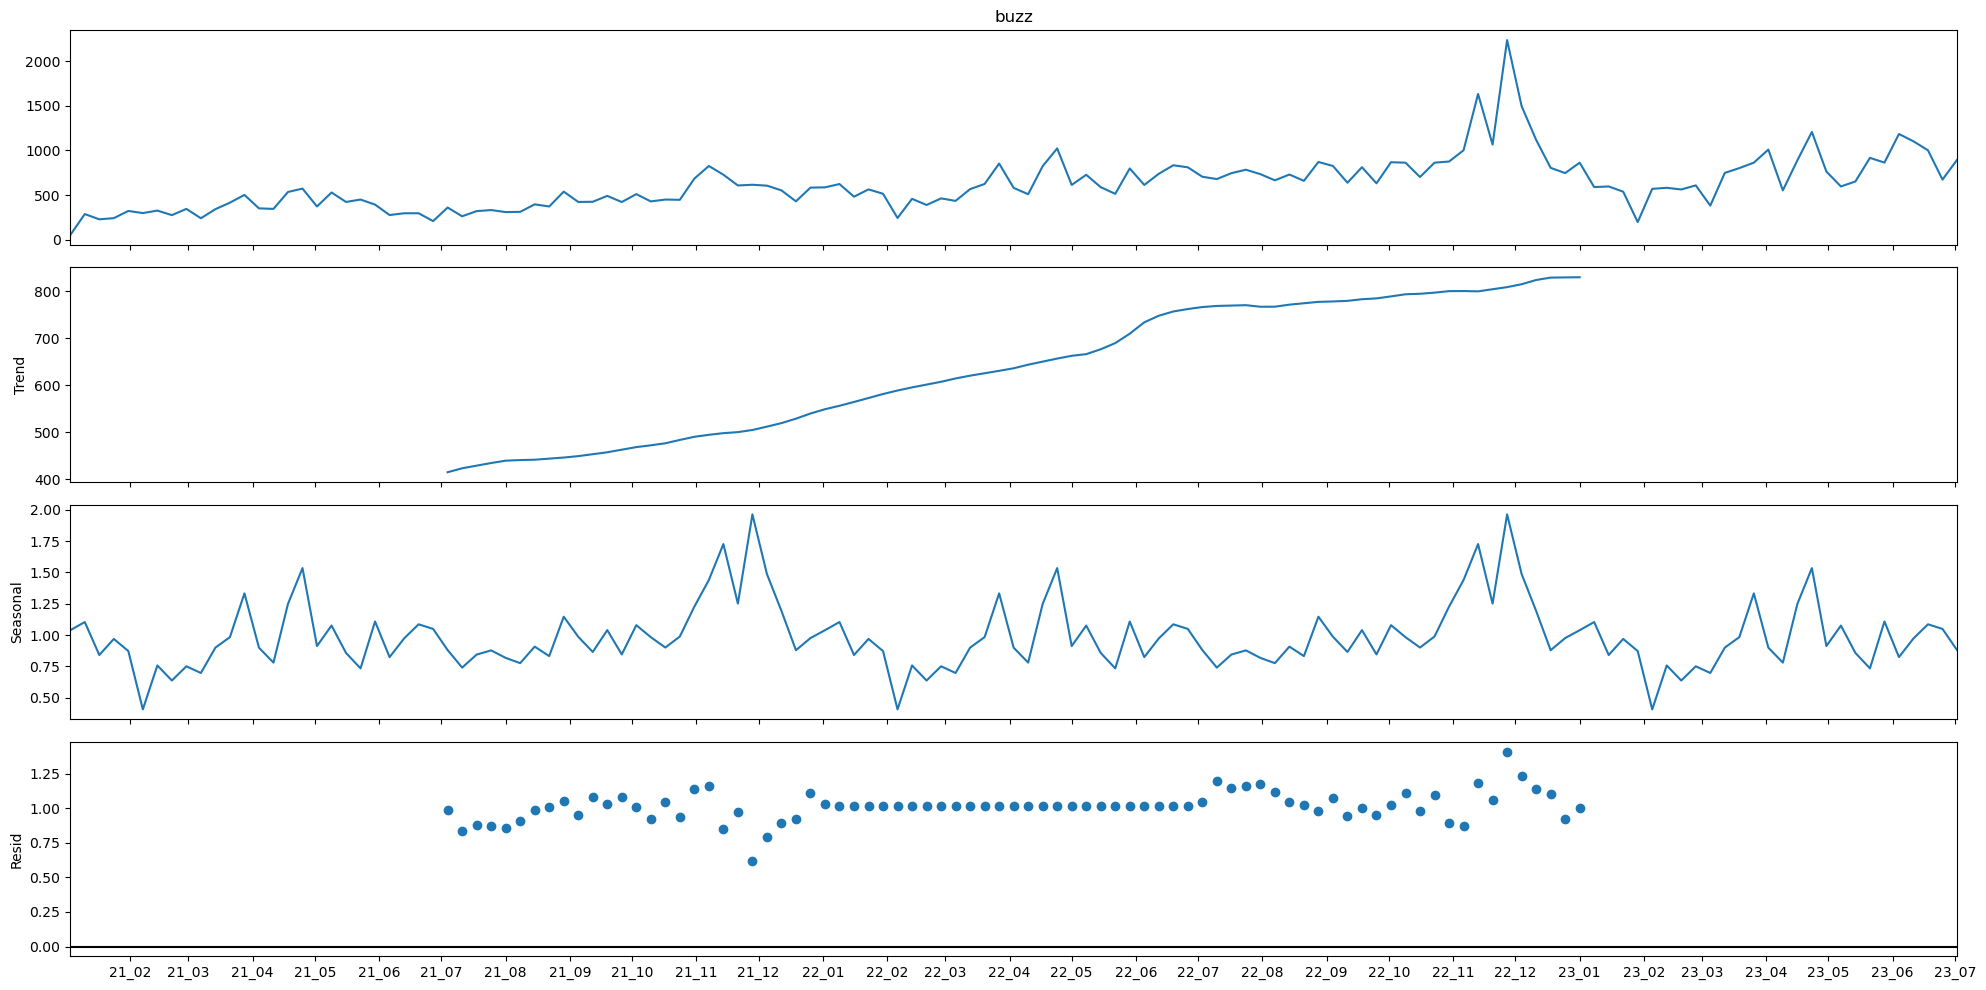

上圖已儲存至綠色飲食
上圖數據資料已儲存至綠色飲食
分析資料表: time interval: W
單位平均聲量: buzz    620.100145
dtype: float64
最佳模型： Model: multiplicative, Period: 26,  最小的殘差值的絕對值平均： 0.9983950109186843


-------------------------------------------
Period: 13, Model: additive, 殘差值的絕對值平均： 234.6813916240117
Period: 13, Model: multiplicative, 殘差值的絕對值平均： 1.0025107270523477
Period: 26, Model: additive, 殘差值的絕對值平均： 122.81435524716203
Period: 26, Model: multiplicative, 殘差值的絕對值平均： 1.0093856895682636


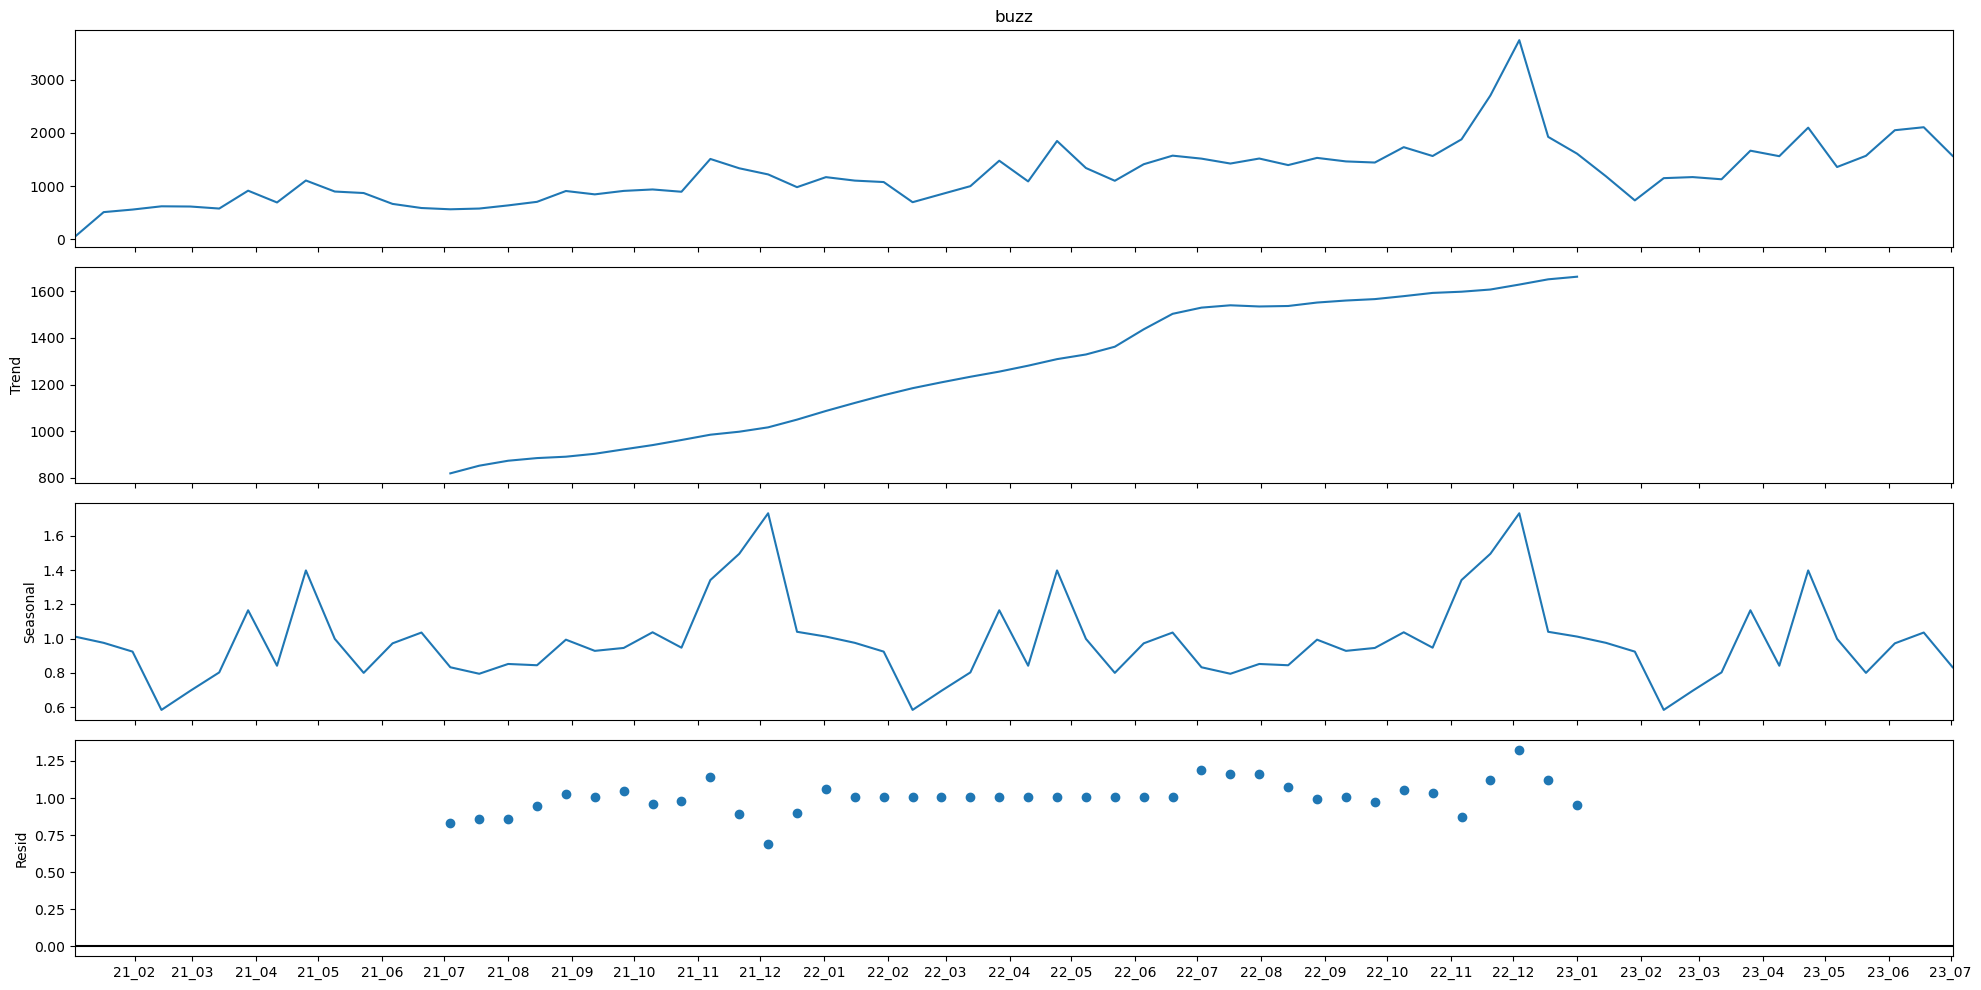

上圖已儲存至綠色飲食
上圖數據資料已儲存至綠色飲食
分析資料表: time interval: 2W
單位平均聲量: buzz    1230.804832
dtype: float64
最佳模型： Model: multiplicative, Period: 13,  最小的殘差值的絕對值平均： 1.0025107270523477


-------------------------------------------


In [22]:
def compare_seasonal_decomposition(df,periods,models,df_name):
  #設定圖的寬度和高度
  plt.rcParams['figure.figsize']=(20,10)

  best_model = None
  best_residual_abs_mean = float('inf')
  for period in periods:
    for model in models:
      try:
        seasonal_decompose_result_tou = sm.tsa.seasonal_decompose(df['buzz'], model=model, period=period)
        # 取得殘差值的絕對值並計算平均
        residual_abs_mean = seasonal_decompose_result_tou.resid.abs().mean()
        print(f'Period: {period}, Model: {model}, 殘差值的絕對值平均： {residual_abs_mean}')

        # 比較模型是否優於先前模型
        if residual_abs_mean < best_residual_abs_mean:
          best_residual_abs_mean = residual_abs_mean
          best_model = (model,period)
      except Exception as e:
        print(f"出現錯誤：{e}")
  seasonal_decompose_result_tou.plot()

  # 設定 x 軸日期格式化
  date_format = mdates.DateFormatter('%y_%m')
  plt.gca().xaxis.set_major_formatter(date_format)

  # 設定 x 軸日期切分點為一個月
  month_locator = mdates.MonthLocator()
  plt.gca().xaxis.set_major_locator(month_locator)

  # 應用圖的大小設定
  plt.gcf().set_size_inches(20, 10)

  #儲存結果圖
  png_output_path = url_base + df_name+ '時間序列拆解圖.png'
  plt.savefig(png_output_path,dpi=300)
  plt.show()
  print(f'上圖已儲存至{url_base[:len(url_base)-1]}')


  # 創建一個新的 DataFrame，包含時間、趨勢、季節性和殘差
  data_output = pd.DataFrame({
    '時間': seasonal_decompose_result_tou.trend.index,
    '趨勢': seasonal_decompose_result_tou.trend,
    '季節性': seasonal_decompose_result_tou.seasonal,
    '殘差': seasonal_decompose_result_tou.resid
  })

  # 將 DataFrame 輸出為 CSV 檔案
  print(f'上圖數據資料已儲存至{url_base[:len(url_base)-1]}')
  output_path = url_base+ df_name+ '時間序列拆解.csv'
  data_output.to_csv(output_path,encoding='utf-8-sig')

  print(f'分析資料表: {df_name}')
  print(f'單位平均聲量: {df.mean()}')
  print(f'最佳模型： Model: {best_model[0]}, Period: {best_model[1]},  最小的殘差值的絕對值平均： {best_residual_abs_mean}')
  print(f'\n\n-------------------------------------------')
  return seasonal_decompose_result_tou.seasonal

# 要測試的period和model參數

periods_to_test_list = [[int(365/2), 365], # D的半年週期與一年週期，因為一年約有365天。
           [int(52/2),52],   # W的半年週期與一年週期，因為一年約有52週。
           [int(26/2),26]]   # 2W的半年週期與一年週期
models_to_test = ['additive', 'multiplicative']

# 使用函數進行比較和繪製
for df_new, df_name, periods_to_test in zip(df_new_list, df_name_list,periods_to_test_list):
  compare_seasonal_decomposition(df_new, periods_to_test, models_to_test,df_name)